# <center>Lab 1</center>

## <center> Optical Digit Recognition </center>

<img src=./digits-classification.jpg>

### Description:

The scope of this exercise is the implementation of __an optical digit recognition system__. Our dataset comes from __US Postal Service__, written by hand (scanned from postal envelopes), and contains digits from 0 to 9 separated in train and test set.

### Data:

We are given two text files (train.txt and text.txt). Each line corresponds to a sample-digit and each collumn corresponds to a features of the digit. For example, the value (i, j) is the j-th feature of the i-th digit. Every digit is described from 257 values. The first value is the class (if it is 0, 1 etc) and the rest 256 values are the pixels that describe it in grayscale. 

### Implementation:

First, we import all the necessary libraries and suppress some unnecessary warnings.

In [1]:
# various
import numpy as np
from matplotlib import pyplot as plt
import random
import scipy.stats

# sklearn 
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier

# pytorch
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch import optim

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### The first 13 steps were implemented as a part of the PrepareLab located in prepare_lab folder.

__Step 1:__ Read input data from given text files.

In [3]:
# Define useful variables
data_path = "./pr_lab1_2016-17_data_0/pr_lab1_2016-17_data"
train_size = 7291
test_size = 2007
n_features = 256

# Initialize X_train, X_test, y_train, y_test
X_train = np.zeros((train_size, n_features), dtype=np.float64)
X_test = np.zeros((test_size, n_features), dtype=np.float64)
y_train = np.zeros(train_size, dtype='int64')
y_test = np.zeros(test_size, dtype='int64')

# Read train data
with open(data_path + "/train.txt") as f:
    for i, line in enumerate(f):
        # Split i-th line
        line = line.split()
        # Keep the first collumn as the class of the i-th digit
        y_train[i] = int(float(line[0]))
        # Keep the rest 256 values as the pixels of the i-th digit.
        for j, pixel in enumerate(line[1:]):
            X_train[i][j] = pixel
    print("Finished reading training data.")

# Read test data
with open(data_path + "/test.txt") as f:
    for i, line in enumerate(f):
        # Split i-th line
        line = line.split()
        # Keep the first collumn as the class of the i-th digit
        y_test[i] = int(float(line[0]))
        # Keep the rest 256 values as the pixels of the i-th digit.
        for j, pixel in enumerate(line[1:]):
            X_test[i][j] = pixel
    print("Finished reading test data.")

Finished reading training data.
Finished reading test data.


__Step 2:__ Display a certain sample (index 131) as an 16x16 image.

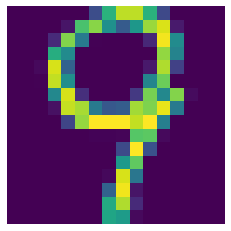

In [4]:
# Reshape the 256 vector in a 16x16 matrix.
img_131 = np.reshape(X_train[131], (16, 16)) 
# Turn the axis off and display the image.
plt.axis('off')
plt.imshow(img_131)

__Step 3:__ Display one random image from each digit.

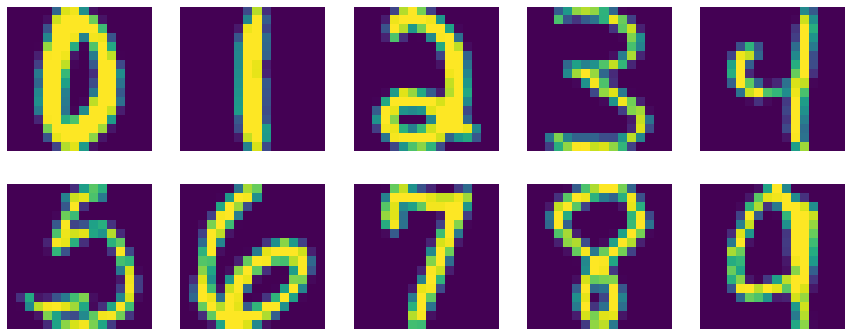

In [5]:
# Define a figure with 10 plots.
fig = plt.figure(figsize=(15,6))
columns = 5
rows = 2

for digit in range(10):
    # Pick all images of current digit
    curr_data = []
    for j, y in enumerate(y_train):
        if y == digit:
            curr_data.append(X_train[j])
    # Select randomly an image
    sample = random.choice(curr_data)
    # Display the randomly selected image in a subplot
    fig.add_subplot(rows, columns, digit+1)
    plt.axis('off')
    plt.imshow(np.reshape(sample, (16, 16)))
plt.show()

__Step 4:__ Compute the mean value of pixel (10,10) of all 0's in the train set.

In [6]:
# Get indexes of 0's in the train set
idx_0 = [i for i in range(train_size) if y_train[i] == 0]

# Get pixel (10,10) of all 0's
X_train_0_10 = np.take(X_train[:, 10*16+10], idx_0)

# Compute mean
mean_0_10 = np.mean(X_train_0_10)
print("Mean value of pixel (10, 10) of all 0's in the train set is: " + str(mean_0_10))

Mean value of pixel (10, 10) of all 0's in the train set is: -0.5041884422110553


__Step 5:__ Compute variance of (10,10) pixel of all 0's in the train set

In [7]:
var_0_10 = np.var(X_train_0_10)
print("Variance of pixel (10, 10) of all 0's in the train set is: " + str(var_0_10))

Variance of pixel (10, 10) of all 0's in the train set is: 0.5245221428814929


__Step 6:__ Compute mean value and variance of every pixel of 0's in the train set

In [8]:
# Get pixels of all 0's
X_train_0 = np.take(X_train, idx_0, axis=0)
# Compute mean value along each pixel
mean_0 = np.mean(X_train_0, axis=0, keepdims=True)
# Compute variance along each pixel
var_0 = np.var(X_train_0, axis=0, keepdims=True)

# Verify their shape
print("Shape of mean values: " + str(mean_0.shape))
print("Shape of variances: " + str(var_0.shape))

Shape of mean values: (1, 256)
Shape of variances: (1, 256)


__Step 7:__ Display digit '0' using the mean value of each pixel.

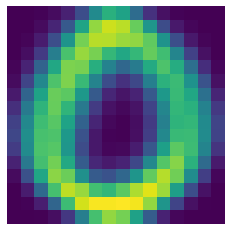

In [9]:
plt.axis("off")
plt.imshow(np.reshape(mean_0, (16, 16)))

__Step 8:__ Display '0' using the variance of each pixel.

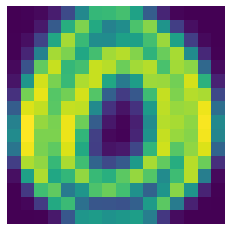

In [10]:
plt.axis("off")
plt.imshow(np.reshape(var_0, (16, 16)))

We observe that the digit in the mean-image contains less noise than in the variance-image. However, in both images the digit can be distinguished.

__Step 9:__ 

__(a)__ Compute the mean value and the variance for all digits (0-9).

In [11]:
mean = np.zeros((10, 256))
var = np.zeros((10, 256))

for digit in range(10):
    idx_i = [i for i in range(train_size) if y_train[i] == digit]
    X_train_i = np.take(X_train, idx_i, axis=0)
    mean[digit, :] = np.mean(X_train_i, axis=0, keepdims=True)
    var[digit, :] = np.var(X_train_i, axis=0, keepdims=True)

__(b)__ Display all digits using their computed mean value.

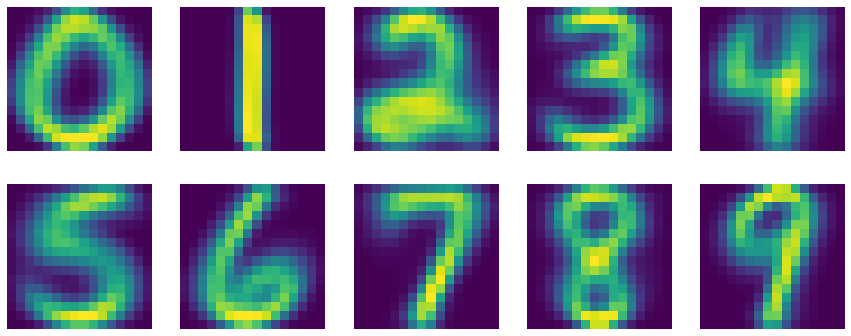

In [12]:
fig = plt.figure(figsize=(15,6))
columns = 5
rows = 2

for digit in range(10):
    fig.add_subplot(rows, columns, digit+1)
    plt.axis('off')
    plt.imshow(np.reshape(mean[digit, :], (16, 16)))
plt.show()

__Step 10:__ Classify X_test[101], using Euclidean distance.

In [13]:
# Define a function that classifies a sample based on the 
# euclidean distance.
def predict_eucl(x):
    pred = 0
    dist = np.linalg.norm(x - mean[0, :])

    for i in range(1, 10):
        if np.linalg.norm(x - mean[i, :]) < dist:
            dist = np.linalg.norm(x - mean[i, :])
            pred = i
    return pred

print("Prediction: " + str(predict_eucl(X_test[101])))
print("Ground truth: " + str(y_test[101]))

Prediction: 0
Ground truth: 6


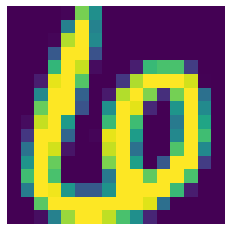

In [14]:
plt.axis('off')
plt.imshow(np.reshape(X_test[101], (16, 16)))

We observe that the classification is wrong, since X_test[101] is the digit 6.

__Step 11:__ 

__(a)__ Classify test set using Euclidean distance

In [15]:
# Compute predictions for each test sample
y_pred = np.zeros(test_size)

for i, x in enumerate(X_test):
    y_pred[i] = predict_eucl(x)

__(b)__ Compute accuracy

In [16]:
# Count number of correct predictions and output the total accuracy.
corr = 0
for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
        corr += 1

acc = corr / len(y_test) * 100
print("Accuracy of Euclidean classifier in test set: " + str(acc))

Accuracy of Euclidean classifier in test set: 81.41504733432984


__Step 12:__ Create a scikit-learn euclidean estimator

In [17]:
class EuclideanClassifier(BaseEstimator, ClassifierMixin):  
    """Classify samples based on the distance from the mean feature value"""

    def __init__(self):
        self.X_mean_ = None
        self.classes_ = None


    def fit(self, X, y):
        """
        This should fit classifier. All the "work" should be done here.
        
        Calculates self.X_mean_ based on the mean 
        feature values in X for each class.
        
        self.X_mean_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        fit always returns self.
        """
        
        # Compute classes
        self.classes_ = np.unique(y)
        
        train_size, n_features = X.shape
        n_classes = len(self.classes_)
        self.X_mean_ = np.zeros((n_classes, n_features))

        for k in range(n_classes):
            idx_i = [i for i in range(train_size) if y[i] == k]
            X_k = np.take(X, idx_i, axis=0)
            self.X_mean_[k, :] = np.mean(X_k, axis=0, keepdims=True)
        
        return self


    def predict(self, X):
        """
        Make predictions for X based on the
        euclidean distance from self.X_mean_
        """
        closest = np.argmin(euclidean_distances(X, self.X_mean_), axis=1)
        return closest
    
    def score(self, X, y):
        """
        Return accuracy score on the predictions
        for X based on ground truth y
        """
        corr = 0
        y_pred = self.predict(X)
        corr = sum(int(y[i] == y_pred[i]) for i in range(len(y)))
        acc = corr / len(y)
        return acc

__Step 13:__

__(a)__ Score above euclidean classifier using 5-fold cross-validation

In [18]:
# Define a custom scorer
def my_scorer(clf, X, y_true):
    return clf.score(X, y_true)

# Create the classifier
clf = EuclideanClassifier()
scores = cross_val_score(clf, X_train, y_train, 
                         cv=KFold(n_splits=5, random_state=42), 
                         scoring=my_scorer)

print("Euclidean Classifier score from 5-fold cross-validation = %f +-%f" % (np.mean(scores), np.std(scores)))

Euclidean Classifier score from 5-fold cross-validation = 0.848580 +-0.001816


__(b)__ Plot the decision surface of the euclidean classifier

In [19]:
# Define a function that plots the decision surface of 2-dimensional data
def plot_clf(clf, X, y, labels):
    fig, ax = plt.subplots()
    # title for the plots
    title = ('Decision surface of Classifier')
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    
    
    x_min, x_max = X0.min() - 1, X0.max() + 1
    y_min, y_max = X1.min() - 1, X1.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .05),
                         np.arange(y_min, y_max, .05))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    out = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    
    zero = ax.scatter(
        X0[y == 0], X1[y == 0],
        c='blue', label=labels[0],
        s=60, alpha=0.9, edgecolors='k')
    
    one = ax.scatter(
        X0[y == 1], X1[y == 1],
        c='red', label=labels[1], 
        s=60, alpha=0.9, edgecolors='k')
    
    two = ax.scatter(
        X0[y == 2], X1[y == 2],
        c='purple', label=labels[2], 
        s=60, alpha=0.9, edgecolors='k')
    
    three = ax.scatter(
        X0[y == 3], X1[y == 3],
        c='green', label=labels[3],
        s=60, alpha=0.9, edgecolors='k')
    
    four = ax.scatter(
        X0[y == 4], X1[y == 4],
        c='gray', label=labels[4], 
        s=60, alpha=0.9, edgecolors='k')
    
    five = ax.scatter(
        X0[y == 5], X1[y == 5],
        c='orange', label=labels[5], 
        s=60, alpha=0.9, edgecolors='k')
    
    six = ax.scatter(
        X0[y == 6], X1[y == 6],
        c='black', label=labels[6],
        s=60, alpha=0.9, edgecolors='k')
    
    seven = ax.scatter(
        X0[y == 7], X1[y == 7],
        c='pink', label=labels[7], 
        s=60, alpha=0.9, edgecolors='k')
    
    eight = ax.scatter(
        X0[y == 8], X1[y == 8],
        c='white', label=labels[8], 
        s=60, alpha=0.9, edgecolors='k')
    
    nine = ax.scatter(
        X0[y == 9], X1[y == 9],
        c='yellow', label=labels[9],
        s=60, alpha=0.9, edgecolors='k')

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    plt.show()

Since our data is 256-dimensional, we should apply a dimensionality reduction technique in order to plot them in 3D space. We choose to use PCA.

In [20]:
# Define PCA
pca = PCA(n_components=2)
pca.fit(X_train)
# Apply PCA on train and test set
X_train_2d = pca.transform(X_train)
X_test_2d = pca.transform(X_test)

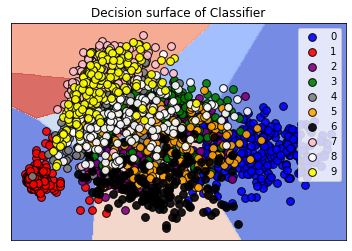

In [21]:
# Train a classifier in th 2D data and plot the decision boundary.
clf = EuclideanClassifier()
clf.fit(X_train_2d, y_train)

plot_clf(clf, X_test_2d, y_test, [i for i in range(10)])

The plot is a bit complex, since we have 10 classes instead of 2. 

__(c)__ Plot the learning curve of the euclidean classifier.

In [22]:
# Function from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

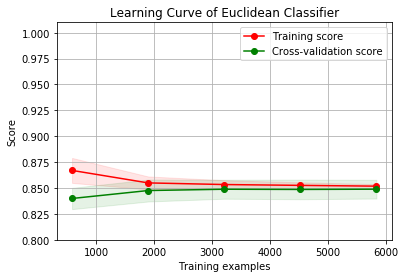

In [23]:
title = "Learning Curve of Euclidean Classifier"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = EuclideanClassifier()
plot_learning_curve(estimator, title, X_train, y_train, (0.8, 1.01), cv=cv, n_jobs=8)

plt.show()

#### The next steps are implemented as part of the main lab

__Step 14:__ Compute the a-priori probabilities of each class, using the above formula:

\begin{align*}
prior(c_i) = \frac{N_i}{N}
\end{align*}

where $N_i$ is the number of the training samples that represent digit i and $N$ is the training size.

In [24]:
prior = np.bincount(y_train.astype(int)) / train_size
for i in range(10):
    print("Digit " + str(i) + ": " + str(prior[i]))

# For testing puproses
print("Sum is equal to: " + str(sum(prior)))

Digit 0: 0.16376354409546015
Digit 1: 0.13784117405019888
Digit 2: 0.10026059525442327
Digit 3: 0.09024825126868742
Digit 4: 0.08942531888629818
Digit 5: 0.07625840076807022
Digit 6: 0.09107118365107666
Digit 7: 0.08846523110684405
Digit 8: 0.07433822520916199
Digit 9: 0.08832807570977919
Sum is equal to: 1.0


__Step 15:__ 

__(a)__ Creation of a Gaussian Naive Bayes classifier using NumPy.

The Naive Bayes classifier is based on the above equation:

\begin{align*}
posterior = \frac{likelihood * prior}{evidence}
\end{align*}

or more formally,

\begin{align*}
P(c_i | x) = \frac{P(x | c_i) * P(c_i)}{P(c_i)}
\end{align*}

In practice, there is interest only in the numerator of that fraction, because the denominator does not depend on C and the values of the features $x_{i}$ are given, so that the denominator is effectively constant. The prior probabilities $P(c_i)$ can be computed as above and the likelihood $P(x | c_i)$ is taken from a normal distribution with the mean value and the variance of the corresponding pixel. After computing the above fraction, the class with the maximum posterior probability is taken. This is known as the maximum a posteriori or MAP decision rule.

\begin{align*}
y = argmax_{k \in {0, .., 9}} P(c_k) \prod_{i=i}^k P(x_i | c_k)
\end{align*}


In [25]:
class GaussianNB_np(BaseEstimator, ClassifierMixin):  
    """Classify samples based on the Gaussian Naive Bayes"""

    def __init__(self):
        self.X_mean_ = None
        self.X_var_ = None
        self.prior = None
        self.n_classes = None


    def fit(self, X, y):
        """
        This should fit classifier. All the "work" should be done here.
        
        Calculates self.X_mean_ and self.X_var_ based on the mean 
        feature values in X for each class. Also, calculates self.prior
        that contains the prior probability of each class.
        
        self.X_mean_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.X_var_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.prior becomes a numpy.array of shape 
        (n_classes)
        
        fit always returns self.
        """

        # Initialize useful variables
        train_size, n_features = X.shape
        self.n_classes = len(np.unique(y))
        self.X_mean_ = np.zeros((self.n_classes, n_features))
        self.X_var_ = np.zeros((self.n_classes, n_features))

        # Compute mean and variance values for each class
        for k in range(self.n_classes):
            idx_i = [i for i in range(train_size) if y[i] == k]
            X_k = np.take(X, idx_i, axis=0)
            self.X_mean_[k, :] = np.mean(X_k, axis=0, keepdims=True)
            self.X_var_[k, :] = np.var(X_k, axis=0, keepdims=True)
        
        # Compute prior probabilities for each class
        self.prior = np.bincount(y.astype(int)) / train_size
        
        return self
        

    def predict(self, X, smooth=None):
        """
        Make predictions for X based on
        the highest posterior probability
        """
        
        # Compute likelihood
        like = np.zeros((self.n_classes, len(X)))
        # Define e for calculation stability (division by zero).
        if smooth:
            e = smooth
        else:
            e = 10**(-9)
        for i in range(self.n_classes):
            like[i] = np.prod(1/(np.sqrt(2*np.pi*self.X_var_[i]+ e)) * \
                              np.exp(-0.5*((X - self.X_mean_[i])**2 / (self.X_var_[i] + e))), axis=1)
        return np.argmax(like.T * self.prior, axis=1)
    
    def score(self, X, y, smooth=None):
        """
        Return accuracy score on the predictions
        for X based on ground truth y
        """
        corr = 0
        y_pred = self.predict(X, smooth)
        corr = sum(int(y[i] == y_pred[i]) for i in range(len(y)))
        acc = corr / len(y)
        return acc

__(b)__ Compute the accuracy of the above classifier using different smoothing parameters.

In [26]:
# Define a custom scorer
def my_scorer(clf, X, y_true):
    return clf.score(X, y_true)

# Define the classifier 
gaussNB_np = GaussianNB_np()
gaussNB_np.fit(X_train, y_train)

print("Accuracy of custom NumPy GaussianNB classifier")
print()

# Predict using default smoothing.
print("Smoothing 1e-9: " + str(gaussNB_np.score(X_test, y_test)))

# Predict using 1e-6 smoothing.
print("Smoothing 1e-6: " + str(gaussNB_np.score(X_test, y_test, smooth=10**(-6))))

# Predict using 1e-3 smoothing.
print("Smoothing 1e-3: " + str(gaussNB_np.score(X_test, y_test, smooth=10**(-3))))

# Predict using 1 smoothing.
print("Smoothing 1: " + str(gaussNB_np.score(X_test, y_test, smooth=1)))

Accuracy of custom NumPy GaussianNB classifier

Smoothing 1e-9: 0.7169905331340309
Smoothing 1e-6: 0.7309417040358744


/home/panos/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/panos/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Smoothing 1e-3: 0.7608370702541106
Smoothing 1: 0.3024414549078226


__(c)__ Compare our custom implementation with scikit-learn GaussianNB implementation.

In [27]:
# Define the sklearn classifier (default smoothing is 1e-9)
gaussNB = GaussianNB()

gaussNB.fit(X_train, y_train)

print("Accuracy of sklearn GaussianNB classifier")
print()

print(gaussNB.score(X_test, y_test))

Accuracy of sklearn GaussianNB classifier

0.7194818136522172


We observe that the accuracy between the NumPy and the sklearn Gaussian Naive Bayes classifiers are very close. However, when we are changing the smoothing factor, the NumPy implementation can perform a little better.

__Step 16:__ Repeat Step 15, supposing that the variance of all features for all classes is equal to 1.

In [28]:
class GaussianNB_np_var1(BaseEstimator, ClassifierMixin):  
    """Classify samples based on the Gaussian Naive Bayes"""

    def __init__(self):
        self.X_mean_ = None
        self.X_var_ = None
        self.prior = None
        self.n_classes = None


    def fit(self, X, y):
        """
        This should fit classifier. All the "work" should be done here.
        
        Calculates self.X_mean_ and self.X_var_ based on the mean 
        feature values in X for each class. Also, calculates self.prior.
        
        self.X_mean_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.X_var_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.prior becomes a numpy.array of shape 
        (n_classes)
        
        fit always returns self.
        """

        # Initialize useful variables
        train_size, n_features = X.shape
        self.n_classes = len(np.unique(y))
        self.X_mean_ = np.zeros((self.n_classes, n_features))
        
        # Set the variance equal to 1.
        self.X_var_ = np.ones((self.n_classes, n_features))

        # Compute mean for each class
        for k in range(self.n_classes):
            idx_i = [i for i in range(train_size) if y[i] == k]
            X_k = np.take(X, idx_i, axis=0)
            self.X_mean_[k, :] = np.mean(X_k, axis=0, keepdims=True)
                
        # Compute prior probabilities for each class
        self.prior = np.bincount(y.astype(int)) / train_size
        
        return self
        

    def predict(self, X, smooth=None):
        """
        Make predictions for X based on
        the highest posterior probability
        """
        
        # Compute likelihood
        like = np.zeros((self.n_classes, len(X)))
        # Define e for calculation stability (division by zero).
        if smooth:
            e = smooth
        else:
            e = 10**(-9)
        for i in range(self.n_classes):
            like[i] = np.prod(1/(np.sqrt(2*np.pi*self.X_var_[i]+ e)) * \
                              np.exp(-0.5*((X - self.X_mean_[i])**2 / (self.X_var_[i] + e))), axis=1)
        return np.argmax(like.T * self.prior, axis=1)
    
    def score(self, X, y, smooth=None):
        """
        Return accuracy score on the predictions
        for X based on ground truth y
        """
        corr = 0
        y_pred = self.predict(X, smooth)
        corr = sum(int(y[i] == y_pred[i]) for i in range(len(y)))
        acc = corr / len(y)
        return acc

In [29]:
# Define a custom scorer
def my_scorer(clf, X, y_true):
    return clf.score(X, y_true)

# Define the classifier
gaussNB_np_var1 = GaussianNB_np_var1()
gaussNB_np_var1.fit(X_train, y_train)

print("Accuracy of custom NumPy GaussianNB classifier, considering unit variance")
print()

# Predict using  default smoothing.
print("Smoothing 1e-9: " + str(gaussNB_np_var1.score(X_test, y_test)))

# Predict using 1e-6 smoothing.
print("Smoothing 1e-6: " + str(gaussNB_np_var1.score(X_test, y_test, smooth=10**(-6))))

# Predict using 1e-3 smoothing.
print("Smoothing 1e-3: " + str(gaussNB_np_var1.score(X_test, y_test, smooth=10**(-3))))

# Predict using 1 smoothing.
print("Smoothing 1: " + str(gaussNB_np_var1.score(X_test, y_test, smooth=1)))

Accuracy of custom NumPy GaussianNB classifier, considering unit variance

Smoothing 1e-9: 0.8126557050323866
Smoothing 1e-6: 0.8126557050323866
Smoothing 1e-3: 0.8126557050323866
Smoothing 1: 0.8121574489287494


Let's summarize all the implementations of a Gaussian Naive Bayes classifier in the above table:



| Type | Variance | Smooth | Accuracy |
| :--- | --- | --- | --- |
| Numpy | trained | 1e-9 | 0.717 |
| Numpy | trained | 1e-6 |  0.731 |
| Numpy | trained | 1e-3 | 0.761 |
| Numpy | trained | 1 | 0.302 |
| Sklearn | trained | 1e-9 | 0.719 |
| Numpy | 1 | 1e-9 | __0.813__ |
| Numpy | 1 | 1e-6 | __0.813__ |
| Numpy | 1 | 1e-3 | __0.813__ |
| Numpy | 1 | 1 | 0.812 |


As we can see, if we consider unit variance, accuracy increases by 5-10%.

__Step 17:__ Compare the performance of Naive Bayes, Nearest Neighbors, SVM (using different kernels).

In [30]:
# Define Nearest Neighbors classifier using 3, 5 and 7 number of neighbors.

neigh3 = KNeighborsClassifier(n_neighbors=3)
neigh3.fit(X_train, y_train)

neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(X_train, y_train)


neigh7 = KNeighborsClassifier(n_neighbors=7)
neigh7.fit(X_train, y_train)

print("Accuracy of Nearest Neihbors classifier, considering different number of neighbors")
print()

print("Neighbors = 3: " + str(neigh3.score(X_test, y_test)))
print("Neighbors = 5: " + str(neigh5.score(X_test, y_test)))
print("Neighbors = 7: " + str(neigh7.score(X_test, y_test)))

Accuracy of Nearest Neihbors classifier, considering different number of neighbors

Neighbors = 3: 0.9446935724962631
Neighbors = 5: 0.9446935724962631
Neighbors = 7: 0.9417040358744395


In [31]:
# Define SVM classifier using different kernels.

svm_lin = SVC(kernel="linear", probability=True)  
svm_lin.fit(X_train, y_train)

svm_rbf = SVC(kernel="rbf", probability=True)  
svm_rbf.fit(X_train, y_train)

svm_poly = SVC(kernel="poly", probability=True)  
svm_poly.fit(X_train, y_train)

svm_sigm = SVC(kernel="sigmoid", probability=True) 
svm_sigm.fit(X_train, y_train)

print("Accuracy of SVM classifier, considering different kernels")
print()

print("Kernel = linear: " + str(svm_lin.score(X_test, y_test)))
print("Kernel = rbf: " + str(svm_lin.score(X_test, y_test)))
print("Kernel = poly: " + str(svm_poly.score(X_test, y_test)))
print("Kernel = sigmoid: " + str(svm_sigm.score(X_test, y_test)))

Accuracy of SVM classifier, considering different kernels

Kernel = linear: 0.9262580966616841
Kernel = rbf: 0.9262580966616841
Kernel = poly: 0.9466865969108121
Kernel = sigmoid: 0.9147982062780269


Best implementations so far:

| Classifier | Type | Accuracy |
| :--- | --- | --- |
| SVM | poly kernel | 0.947 |
| NN  | 3 neighbors | 0.945 |
| NN  | 5 neighbors | 0.945 |
| NN  | 7 neighbors | 0.942 |
| SVM | rbf kernel | 0.926 |
| SVM | linear kernel | 0.926 |
| SVM | sigmoid kernel | 0.915 |
| GaussianNB | var = 1 | 0.813 |


All Nearest Neighbors implementations along with the poly SVM have almost 95% accuracy. As we expected, the Naive Bayes classifiers perform worse than the other classifiers, due to their simplicity.

__Step 18:__ This step aims to combine different classifiers to achieve higher accuracy. This technique is known as __ensembling__. It is important that the combined classifiers misclassify different classes, e.g. classifier 1 tends to misclassify digit 3 and classifier 2 tends to misclassify digit 7 e.t.c . 

First, let's check the type of misprediction for each of the above classifiers.

In [32]:
n_classifiers = 8
names = ["svm_poly", "neigh3", "neigh5", "neigh7", "svm_rbf", "svm_lin", "svm_sigm", "gaussNB_np_var1"]
classifiers = [svm_poly, neigh3, neigh5, neigh7, svm_rbf, svm_lin, svm_sigm, gaussNB_np_var1]
misses = np.zeros((n_classifiers, 10))

for i, clf in enumerate(classifiers):
    y_pred = clf.predict(X_test)
    for j in range(len(y_pred)):
        if y_pred[j] != y_test[j]:
            misses[i, int(y_test[j])] += 1
        

In [33]:
print("Number of digits not correctly classified for each classifier:")
print()
for i in range(8):
    print(names[i])
    print(misses[i])
    print()

Number of digits not correctly classified for each classifier:

svm_poly
[ 4.  9. 15. 16. 11. 10. 12. 10. 13.  7.]

neigh3
[ 4.  6. 15. 13. 17. 16.  7.  9. 15.  9.]

neigh5
[ 5.  5. 16. 12. 17. 16.  7.  9. 15.  9.]

neigh7
[ 5.  6. 16. 11. 18. 14.  8.  9. 21.  9.]

svm_rbf
[ 4.  9. 17. 20. 12. 13. 11. 10. 13.  7.]

svm_lin
[ 8.  8. 17. 20. 20. 24. 10. 12. 22.  7.]

svm_sigm
[ 8.  8. 29. 26. 16. 22. 13. 13. 28.  8.]

gaussNB_np_var1
[62.  5. 53. 35. 50. 38. 27. 30. 39. 37.]



In [34]:
print("Top 3 misclassified digits: ")
print()

for i in range(8):
    best_3 = misses[i].argsort()[-3:][::-1]
    print(names[i] + ": " + str(best_3[0]) + " " + str(best_3[1]) + " " + str(str(best_3[2])))

Top 3 misclassified digits: 

svm_poly: 3 2 8
neigh3: 4 5 8
neigh5: 4 5 2
neigh7: 8 4 2
svm_rbf: 3 2 8
svm_lin: 5 8 4
svm_sigm: 2 8 3
gaussNB_np_var1: 0 2 4


In [35]:
print("Last 3 misclassified digits: ")
print()

for i in range(8):
    last_3 = misses[i].argsort()[:3]
    print(names[i] + ": " + str(last_3[0]) + " " + str(last_3[1]) + " " + str(last_3[2]))

Last 3 misclassified digits: 

svm_poly: 0 9 1
neigh3: 0 1 6
neigh5: 0 1 6
neigh7: 0 1 6
svm_rbf: 0 9 1
svm_lin: 9 0 1
svm_sigm: 0 1 9
gaussNB_np_var1: 1 6 7


__(a)__ Choose some previous classifier and combine them using Voting Classifier.

Considering the above statistics, the combination svm_poly + neigh5 + svm_lin seems like a good choice.

In [36]:
v_clf1 = VotingClassifier(estimators=[('svm_poly', svm_poly), ('neigh5', neigh5), ('svm_lin', svm_lin)], voting='hard')

v_clf1.fit(X_train, y_train)

print("Hard Voting: " + str(v_clf1.score(X_test, y_test)))

Hard Voting: 0.9491778774289985


In [37]:
v_clf2 = VotingClassifier(estimators=[('svm_poly', svm_poly), ('neigh5', neigh5), ('svm_lin', svm_lin)], voting='soft')
v_clf2.fit(X_train, y_train)

print("Soft Voting: " + str(v_clf2.score(X_test, y_test)))


Soft Voting: 0.9501743896362731


__(b)__ Choose a classifier and use the BaggingClassifier to create an ensemble. The bagging technique is used to split the train set in random subsets and fit a classifer in each set.

In [38]:
# Use the best classifier so far.
bag_5 = BaggingClassifier(svm_poly, n_estimators=5)
bag_10 = BaggingClassifier(svm_poly, n_estimators=10)

bag_5.fit(X_train, y_train)
bag_10.fit(X_train, y_train)

print("Bagging svm_poly using 5 estimators: " + str(bag_5.score(X_test, y_test)))
print("Bagging svm_poly using 10 estimators: " + str(bag_10.score(X_test, y_test)))


Bagging svm_poly using 5 estimators: 0.9471848530144494
Bagging svm_poly using 10 estimators: 0.9431988041853513


__(c)__  In general, Bagging reduces overfitting (variance) by averaging or voting. However, in our case it did not incease our model's accuracy. The soft voting classifier achieved the best accuracy, since it combined the pros of different classifiers.

__Step 19:__ Introduction in Neural Networks and Pytorch.

__(a)__ Loading the Data

- Create a Dataset

In [39]:
class PostalDataset(Dataset):
    """
    Our custom PyTorch Dataset, for manipulating US Postal Dataset.
    What we have to do is to implement the 2 abstract methods:
        - __len__(self): in order to let the DataLoader know the size
            of our dataset and to perform batching, shuffling and so on...
        - __getitem__(self, index): we have to return the properly
            processed data-item from our dataset with a given index
    """

    def __init__(self, X, y):
        """
        Args:
            X (list): List of training samples
            y (list): List of training labels
        """
        self.data = X
        self.labels = y

    def __len__(self):
        """
        Must return the length of the dataset, so the dataloader can know
        how to split it into batches
        Returns:
            (int): the length of the dataset
        """
        
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns the idx-th item from the dataset
        Args:
            index (int):
        Returns:
            (tuple):
                * example (ndarray): the training example
                * label (int): the class label
        """
        
        return self.data[idx], self.labels[idx]

- Define a train, dev and test Dataset

Split training set in training and validation set

In [40]:
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

In [41]:
train_set = PostalDataset(X_train, y_train)
val_set = PostalDataset(X_val, y_val)
test_set = PostalDataset(X_test, y_test)

In [42]:
print("Training set size: " + str(len(train_set)))
print("Validation set size: " + str(len(val_set)))
print("Test set size: " + str(len(test_set)))

Training set size: 5103
Validation set size: 2188
Test set size: 2007


- Define a train and a test DataLoader

In [43]:
train_loader = DataLoader(train_set, batch_size=32,
                          shuffle=True, num_workers=8)

val_loader = DataLoader(val_set, batch_size=32,
                          shuffle=True, num_workers=8)

test_loader = DataLoader(test_set, batch_size=32,
                          shuffle=True, num_workers=8)

__(b)__ Define different fully connected neural network architectures.

- Two layer neural network using ReLU activation function.

In [44]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, data):
        hidden =  self.relu(self.linear1(data.float()))
        preds = self.linear2(hidden)
        return preds

- Three layer neural network using ReLU activation function.

In [45]:
class ThreeLayerNet(torch.nn.Module):
    def __init__(self, D_in, H_1, H_2, D_out):
        super(ThreeLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H_1)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(H_1, H_2)
        self.linear3 = torch.nn.Linear(H_2, D_out)

    def forward(self, data):
        hidden_1 =  self.relu(self.linear1(data.float()))
        hidden_2 =  self.relu(self.linear2(hidden_1))
        preds = self.linear3(hidden_2)
        return preds
    

- Two layer neural network using tanh activation function.

In [46]:
class TwoLayerNet_tanh(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet_tanh, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.tanh = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, data):
        hidden =  self.tanh(self.linear1(data.float()))
        preds = self.linear2(hidden)
        return preds

- Three layer neural network using tanh activation function.

In [47]:
class ThreeLayerNet_tanh(torch.nn.Module):
    def __init__(self, D_in, H_1, H_2, D_out):
        super(ThreeLayerNet_tanh, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H_1)
        self.tanh = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(H_1, H_2)
        self.linear3 = torch.nn.Linear(H_2, D_out)

    def forward(self, data):
        hidden_1 =  self.tanh(self.linear1(data.float()))
        hidden_2 =  self.tanh(self.linear2(hidden_1))
        preds = self.linear3(hidden_2)
        return preds

__(c)__ Train the NN in our train data and evaluate it on the validation data.

In [53]:
# D_in is input dimension;
# D_out is output dimension.
D_in, D_out = 256, 10


# Construct our model 
layers = int(input("Number of hidden layers: (1 or 2)"))
if layers == 1:
    size1 = int(input("Size of hidden layer: "))
    size2 = None
else:
    size1 = int(input("Size of 1st hidden layer: "))
    size2 = int(input("Size of 2nd hidden layer: "))

act = input("Activation function: (relu or tanh)")

if layers == 1:
    if act == "relu":
        model = TwoLayerNet(D_in, size1, D_out)
    else:
        model = TwoLayerNet_tanh(D_in, size1, D_out)
else:
    if act == "relu":
        model = ThreeLayerNet(D_in, size1, size1, D_out)
    else:
        model = ThreeLayerNet_tanh(D_in, size1, size2, D_out)

print(model)
print()

# Define criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

prev_val = 0
ep = 1

while True:
    print("Epoch: " + str(ep))
    
    # Train and evaluate on train set
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    
    print('Accuracy in train: %f %%' % (
            100 * correct_train / total_train))
    
    # Evaluate on validation set
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    print('Accuracy in val: %f %%' % (
            100 * correct_val / total_val))
    
    # Stop when validation accuracy stops increasing.
    curr_val = correct_val / total_val
    if curr_val + 0.001 < prev_val:
        break
    prev_val = curr_val
    ep += 1

print('Finished Training')
   

Number of hidden layers: (1 or 2)2
Size of 1st hidden layer: 128
Size of 2nd hidden layer: 64
Activation function: (relu or tanh)tanh
ThreeLayerNet_tanh(
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (tanh): Tanh()
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

Epoch: 1
Accuracy in train: 82.912013 %
Accuracy in val: 88.789238 %
Epoch: 2
Accuracy in train: 94.238683 %
Accuracy in val: 91.131041 %
Epoch: 3
Accuracy in train: 95.610425 %
Accuracy in val: 91.928251 %
Epoch: 4
Accuracy in train: 97.178131 %
Accuracy in val: 91.878426 %
Epoch: 5
Accuracy in train: 97.785616 %
Accuracy in val: 92.725461 %
Epoch: 6
Accuracy in train: 98.353909 %
Accuracy in val: 92.326856 %
Finished Training


In the training we can change the following hyperparameters:
- Model
- Number of layers
- Size of each layer
- Activation functions

In the following table, we summarize the results for different combinations of the above parameters:`

| Hidden Layers | Activation Type | Size of each layer | Epochs | Accuracy (train) | Accuracy (val) |
| --- | --- | --- | --- | --- | --- |
| 1 | ReLU | 16 | 8 | 95.66 |90.98 |
| 1 | ReLU | 32 | 5 | 95.87 | 90.63 |
| 1 | ReLU | 64 | 9 |98.28 | 92.13 |
| 1 | ReLU | 128 | 7 |97.98 | 92.23 |
| --- | --- | --- | --- | --- | --- |
| 2 | ReLU | 32 - 16 | 10 |97.55 | 91.38 |
| 2 | ReLU | 64 - 32 | 10 |98.54 | 91.03 |
| 2 | ReLU | 128 - 64 | 7 |98.47 | 92.18 |
| --- | --- | --- | --- | --- | --- |
| 1 | tanh | 16 | 9 | 96.26 |91.03 |
| 1 | tanh | 32 | 5 | 96 | 91.33 |
| 1 | tanh | 64 | 5 |96.61 | 91.33 |
| 1 | tanh | 128 | 6 |97.43 | 91.78 |
| --- | --- | --- | --- | --- | --- |
| 2 | tanh | 32 - 16 | 9 |98.04 | 92.13 |
| 2 | tanh | 64 - 32 | 8 |98.49 | 91.93 |
| 2 | tanh | 128 - 64 | 11 | 98.36 | __92.33__ |

In [54]:
# Evaluate the best model on test set
# tanh with 2 hidden layers (128 - 65)
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

print(correct_val / total_val)

0.9232685600398605


__(c)__ Convert the PyTorch Neural Network implementation to sklearn compatible.

We will convert the TwoLayerNet.

In [55]:
class NN_sklearn(BaseEstimator, ClassifierMixin):  

    def __init__(self, in_dim, out_dim, hidden_dim, batch_size):
        self.D_in = in_dim
        self.D_out = out_dim
        self.H = hidden_dim
        self.batch_size = batch_size
        self.model = TwoLayerNet(self.D_in, self.H, self.D_out)


    def fit(self, X, y):
        train_set = PostalDataset(X, y)
        train_loader = DataLoader(train_set, batch_size=self.batch_size,
                          shuffle=True, num_workers=8)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters())

        prev_val = 0
        ep = 1

        while True:
            print("Epoch: " + str(ep))
            correct_train = 0
            total_train = 0
            for i, data in enumerate(train_loader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)

                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()


            print('Accuracy in train: %f %%' % (
                    100 * correct_train / total_train))

            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for data in test_loader:
                    images, labels = data
                    outputs = self.model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            print('Accuracy in val: %f %%' % (
                    100 * correct_val / total_val))

            curr_val = correct_val / total_val
            if curr_val + 0.001 < prev_val:
                break
            prev_val = curr_val
            ep += 1
        
        return self


    
    def score(self, X, y):
        """
        Return accuracy score on the predictions
        for X based on ground truth y
        """
        test_set = PostalDataset(X, y)
        test_loader = DataLoader(test_set, batch_size=1, num_workers=8)
        
        correct = 0
        total = 0
        predictions = []
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        return correct/total

In [56]:
NN_sk = NN_sklearn(256, 10, 32, 32)

NN_sk.fit(X_train, y_train)

Epoch: 1
Accuracy in train: 77.131099 %
Accuracy in val: 86.895864 %
Epoch: 2
Accuracy in train: 92.494611 %
Accuracy in val: 89.038366 %
Epoch: 3
Accuracy in train: 94.042720 %
Accuracy in val: 90.832088 %
Epoch: 4
Accuracy in train: 94.885362 %
Accuracy in val: 90.134529 %


NN_sklearn(batch_size=32, hidden_dim=None, in_dim=None, out_dim=None)

__(d)__ Evaluate out NN in our test set.

In [57]:
print("Sklearn combatible NN " + str(NN_sk.score(X_test, y_test)))

Sklearn combatible NN 0.9013452914798207
